# Tcoast example:
This example shows how to compute the transport along the coast of Yucatán, Mexico. The input data corresponds to netCDF from a regional numerical simulation of the Gulf of Mexico using MITgcm.

In [1]:
import xarray as xr
import pylab as plt
import numpy as np
import os
import cmocean as cm
import datetime
from tcoasts import *
%matplotlib inline

## Parallelize:
`tcoasts` uses the `xarray` framework, therefore the parallelization of the code can be achived by using `xarray.datasets` and `dask`. This code has been tested in a HPC system in which the speeds increase significant (wxample will be added).

In [2]:
from dask.distributed import Client

In [3]:
c=Client()
c

Client Scheduler: tcp://127.0.0.1:45386 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


## Import data:

Example data is contained in the data folder. Make sure the provided folder and contourfile include all the directory. In case the coastline file is located in a different path, use the absolute location.

In [4]:
folder='./data/'
contourfile='GoM_coastline.xy'

Distance between vectors along the coast, note that in high resolution coastal contours lakes can decrease significantly the distance between vector locations.
Distance can be provided as an `np.array()` or a list (for example`[0,50,100,150]`)

In [5]:
distance=np.arange(0,200,50)

## Initialize object:

`tcoasts.TransportAlongCoast` is the main class to compute the transport along the coast.

In [6]:
tac=tcoasts.TransportAlongCoast(folder,[-89.75,21.3],contourfile,distance=distance,length=50)

`tcoasts.TransportAlongCoast.inter2vector` is uses the `xarray.interp` method. This function has the same `**kwargs` as `xarray.open_mfdataset`. By default this function will save the interpolation using `xarray.dataset.to_netcdf`, this option is particularly useful when analysing large amounts of data.

In [7]:
tac.inter2vector(ufiles='U.nc',vfiles='V.nc',save=False)

Opening velocity files
Interpolating velocity fields


## Compute transport

The mathematical definition of transport computed by `tcoasts` is:

\begin{equation*}
T = \int \int \left[\vec{u}\cdot\hat{n}\right]\cdot\hat{n} dxdz
\end{equation*}

In [8]:
transport=tac.compute_transport()

## Example of transport:

According with the definiton of tcoasts, positive transport is eastwards to the perpendicular vector (i.e. $\hat{n} > 0$). In the following example, the transport is mostly negative during most of the record. 

This is consistent with the next graph in which the instatanious velocity field at time=51 is shown.

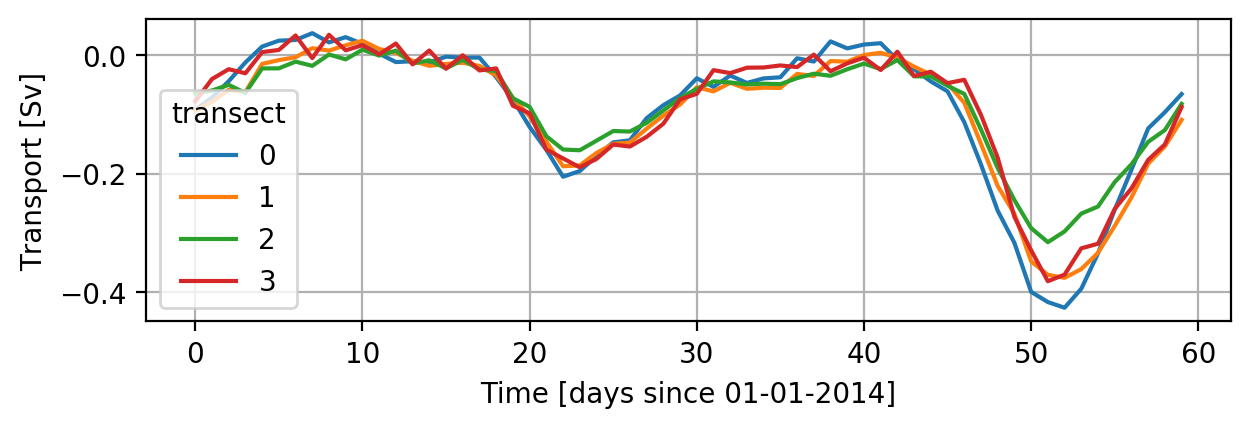

In [9]:
fig,ax=plt.subplots(1,1,figsize=(7,2),dpi=200)
(transport/1e6).plot.line(x='time',ax=ax)
ax.grid()
ax.set_xlabel('Time [days since 01-01-2014]');
ax.set_ylabel('Transport [Sv]');

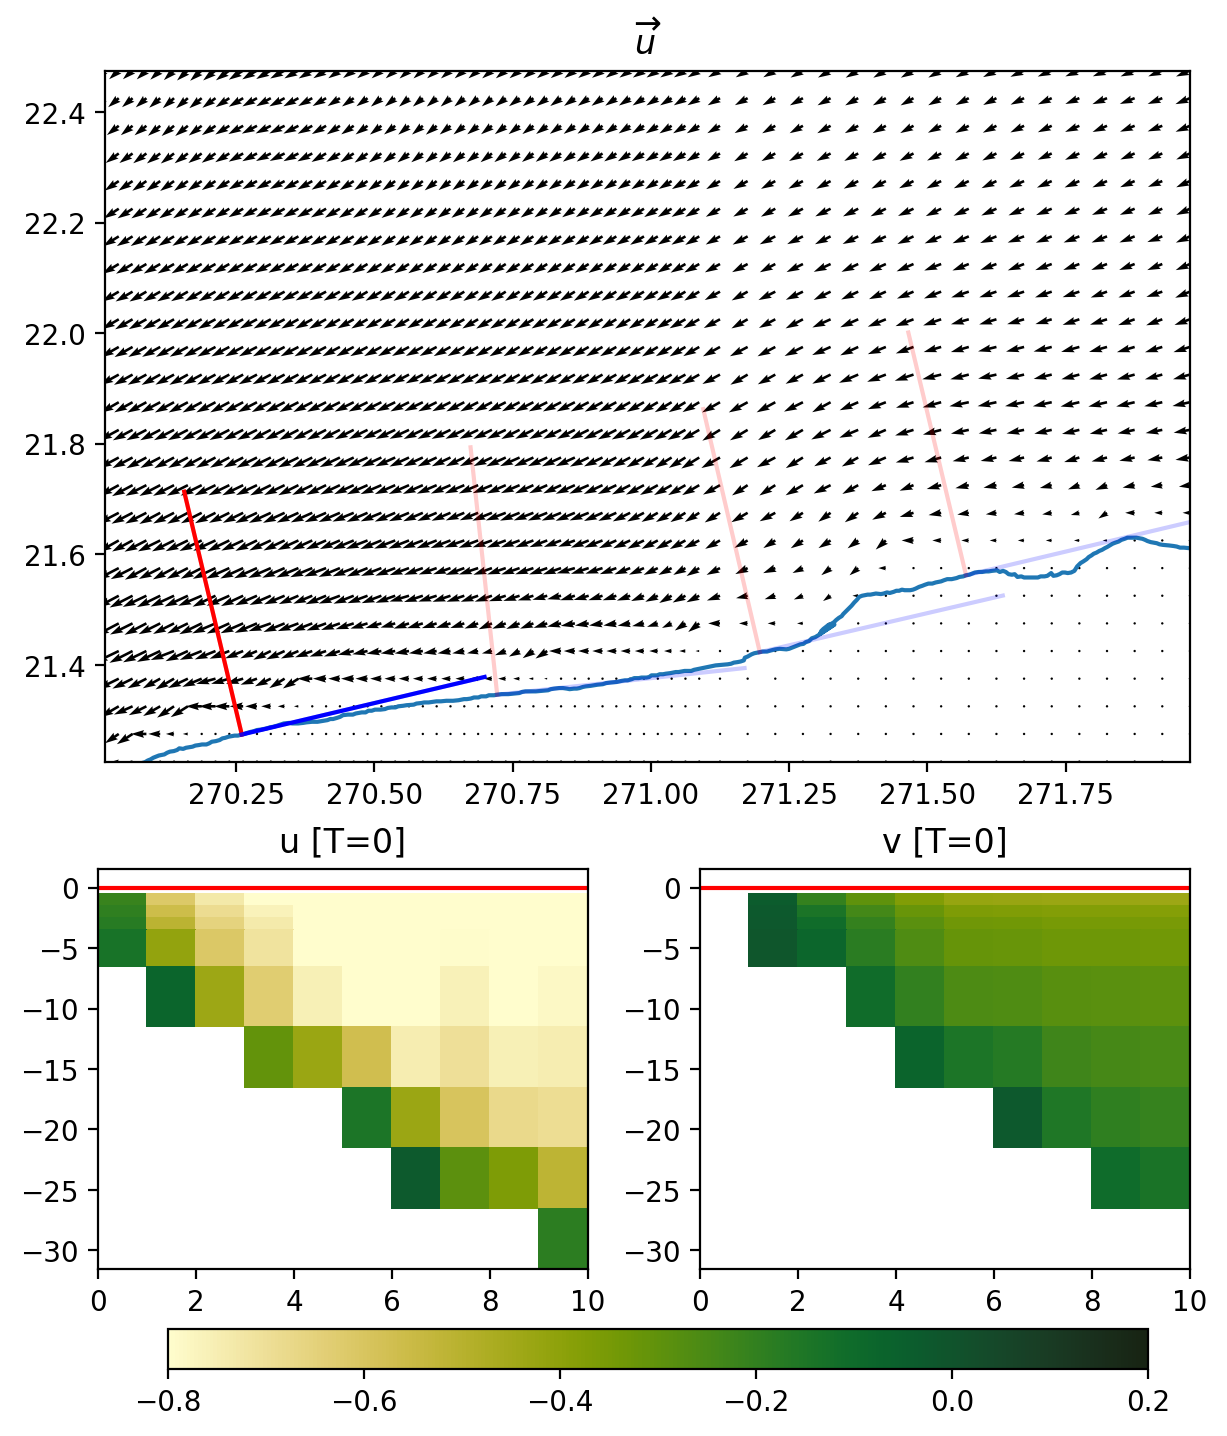

In [10]:
fig,ax=plt.subplots(1,1,figsize=(7,5),dpi=200,sharey=True)

u = tac.loaddata(file='U.nc',combine='nested',concat_dim='time')
v = tac.loaddata(file='V.nc',combine='nested',concat_dim='time')

ax.quiver(u.lon,u.lat,u.isel({'time':51,'depth':0}),v.isel({'time':51,'depth':0}))
ax.set_title('$\overrightarrow{u}$')

ax.plot(tac.coastline[:,0]+360,tac.coastline[:,1])

x_norm,y_norm,x_perp,y_perp,x_perp_all,y_perp_all=tac.vertor_perp(shift=360)

ax.plot(x_perp_all[0],y_perp_all[0],'-r')
ax.plot(x_norm[0],y_norm[0],'-b')

ax.plot(x_perp_all.T,y_perp_all.T,'-r',alpha=0.2)
ax.plot(x_norm.T,y_norm.T,'-b',alpha=0.2)

ax.set_xlim(u.lon.min(),u.lon.max())
ax.set_ylim(u.lat.min(),u.lat.max())

plt.gca().set_aspect('equal', adjustable='box')

ax1 = fig.add_axes([0.12, -0.35, 0.35, 0.4])
plt.pcolormesh(tac.interp_data.u.n,tac.interp_data.u.depth,tac.interp_data.u.isel({'time':51,'transect':0}),vmin=-0.8,vmax=0.2,cmap=cm.cm.speed)
plt.plot(np.arange(0,11),np.arange(0,11)*0,'-r')
ax1.set_title('u [T=0]')

ax1 = fig.add_axes([0.55, -0.35, 0.35, 0.4])
col=plt.pcolormesh(tac.interp_data.u.n,tac.interp_data.u.depth,tac.interp_data.v.isel({'time':51,'transect':0}),vmin=-0.8,vmax=0.2,cmap=cm.cm.speed)
plt.plot(np.arange(0,11),np.arange(0,11)*0,'-r')
ax1.set_title('v [T=0]')

axc = fig.add_axes([0.17, -0.45, 0.7, 0.04])
fig.colorbar(col, cax=axc,orientation='horizontal')

### To know more about `tcoasts` please refer to the online documentation